In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
import mplhep as hep
import pandas as pd
hep.style.use(hep.style.CMS)

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import candidate, vector
from coffea.analysis_tools import Weights, PackedSelection

# we suppress ROOT warnings where our input ROOT tree has duplicate branches - these are handled correctly.
import warnings
import uproot

import warnings

warnings.filterwarnings('ignore')

In [2]:
#fname = "root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/120000/AAAEC7ED-E488-2C45-A141-A5B36AFAF3D5.root"
#fname="root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/B5804595-A8F6-DD46-A224-7C115AD91EAA.root"
fname="root://xcache//store/mc/RunIISummer20UL17NanoAODv2/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/NANOAODSIM/106X_mc2017_realistic_v8-v1/230000/B5804595-A8F6-DD46-A224-7C115AD91EAA.root"

events=NanoEventsFactory.from_root(fname, schemaclass=NanoAODSchema).events()

In [3]:
#*.root
# * en 12000
#Canal de electrón :
  #  Trigger central: Ele40_WPTight_Gsf
  #  Trigger de ref: DoubleEle24_eta2p_WPTight_Gsf

In [4]:
#(CSV)Combined Secondary  Vertex
#(CSVv2) improved version of CSV for Run2: neural network instead of a Likelihood Ratio, additional variables, 
#improved track selection,  use of IVF secondary vertices

#DeepCSVB: deep DNN that retains the simplicity of CSV, with a different ML approach
events.btagWeight.fields

['CSVV2', 'DeepCSVB']

# SELECCIÓN DE EVENTOS

# Trigger


In [5]:

#trigger_de_ref=events.HLT.DoubleEle24_eta2p1_WPTight_Gsf

#trigger_central=events.HLT.Ele40_WPTight_Gsf

trigger_de_ref=events.HLT.DiEle27_WPTightCaloOnly_L1DoubleEG

trigger_central=events.HLT.Ele27_WPTight_Gsf

## Electrón

In [6]:
goodelectron = ((ak.sum(events.Electron.pt>30, axis=1)>1)
                &(ak.firsts(events.Electron.pt) > 60)
                & (((0<abs(ak.firsts(events.Electron.eta))) & (abs(ak.firsts(events.Electron.eta))<2.4)))
                & (((1.57<abs(ak.firsts(events.Electron.eta))) | (abs(ak.firsts(events.Electron.eta))<1.4)))
               )

## b-Jet

In [7]:
#CSVv2M
#https://twiki.cern.ch/twiki/bin/viewauth/CMS/BtagRecommendation80XReReco#Supported_Algorithms_and_Operati
b_jet=events.Jet[events.Jet.btagCSVV2>0.8484]

In [8]:
#identifica b-jet falta
goodbJets = ((ak.sum(b_jet.pt>0, axis=1)>0)
            &(ak.firsts(b_jet.pt)>30)
            &(abs(ak.firsts(b_jet.eta))<2.1)
             )

## Met

In [9]:
goodMet=events.MET.pt>50

# selection

In [10]:
selection=PackedSelection()

In [11]:
selection.add("trigger_de_ref",trigger_de_ref)
selection.add("trigger_central",trigger_central)
selection.add("electron",goodelectron)
selection.add("bJet",goodbJets)
selection.add("Met",goodMet)

In [12]:
#region
regions={"signal_trigger":["trigger_de_ref"],
         "signal_trigger_e":["trigger_de_ref","electron"],
         "signal_trigger_e_bjet":["trigger_de_ref","electron","bJet"],
         "signal_triggerref_e_bjet_met":["trigger_de_ref","electron","bJet","Met"],
}

In [13]:
candidtae_events=events[selection.all(*regions["signal_triggerref_e_bjet_met"])]

In [14]:
candidtae_events.Electron.pt

<Array [[99.8, 89.6], ... [239, 48.3, 7.87]] type='14273 * var * float32[paramet...'>

In [15]:
cut_count_events=[len(events)]
count_regions=["Events"]

In [16]:
cut_count_events=[len(events)]
for i in regions.keys():
    cut_trigger=events[selection.all(*regions[i])]
    cut_count_events.append(len(cut_trigger))
    count_regions.append(i)

In [17]:
cut_count_events

[1158000, 53776, 27870, 20744, 14273]

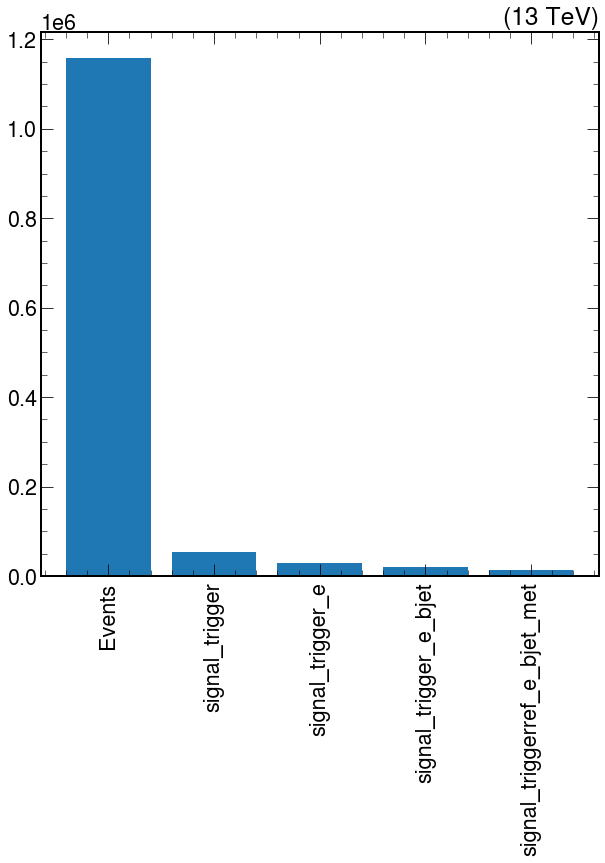

In [18]:
plt.plot(igsize=(12, 4))
#h, bins= np.histogram(data,bins=bines)
hep.cms.lumitext("(13 TeV)")
#hep.cms.text("Work in Progress")
#hep.cms.text("Work in Progress")
plt.bar(count_regions,cut_count_events,align='center',)
plt.xticks(rotation=90)
plt.show()

## se aplica trigger central

In [19]:
regions_2={"signal_trigger_central":["trigger_de_ref","electron","bJet","Met","trigger_central"],
          }


In [20]:
event_select_c=events[selection.all(*regions_2["signal_trigger_central"])]

In [21]:
event_select_c

<NanoEventsArray [<event 1:1669:1668186>, ... ] type='14018 * event'>

# Eficiencia

In [22]:
eficiencia=len(event_select_c)/len(candidtae_events)
eficiencia

0.9821340993484201

# Ratio de eventos 

In [23]:
import mplhep as hep
hep.style.use("CMS")

## Electrón

In [24]:
def plot_cms(data,bines,labels):
    plt.plot(igsize=(12, 4))
    h, bins= np.histogram(data,bins=bines)
    hep.cms.lumitext("(13 TeV)")
    hep.cms.text("Work in Progress")
    hep.histplot(h,bins=bins, density=True,label=labels)
    hep.histplot(h,bins=bins,color="black", density=True,label="Data")
    plt.legend()
    plt.xlabel(labels)
    return h,bins

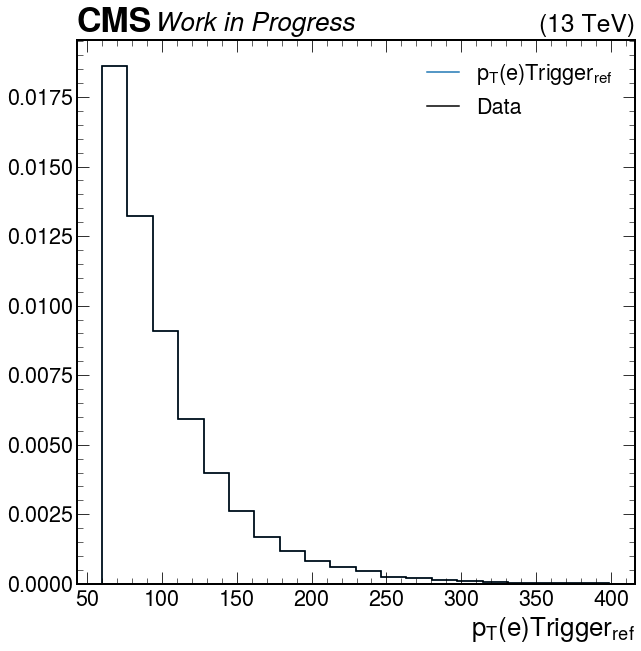

In [25]:
pt_e_tr=ak.firsts(candidtae_events.Electron.pt)
pt_e_tr=pt_e_tr[pt_e_tr<400]
pt_tr,bins_tr=plot_cms(pt_e_tr,bines=20,labels="${p}_{T}(e) Trigger_{ref}$")

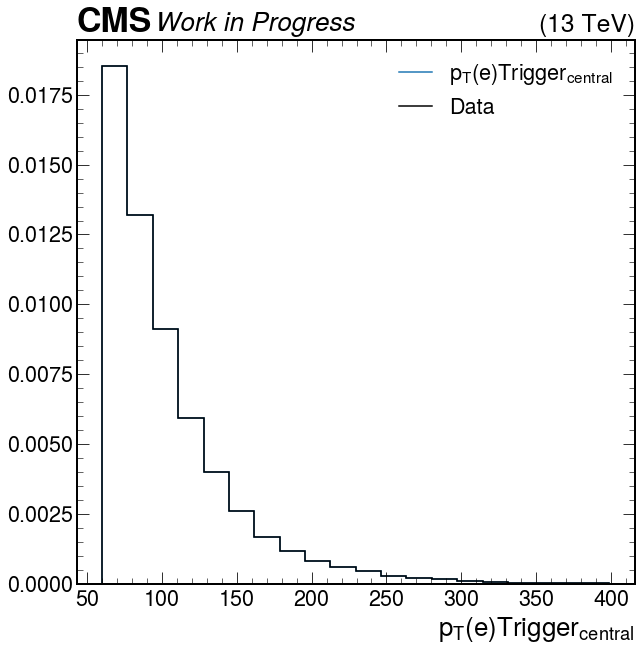

In [26]:
pt_e_tc=ak.firsts(event_select_c.Electron.pt)
pt_e_tc=pt_e_tc[pt_e_tc<400]
pt_tc,bins_tc=plot_cms(pt_e_tc,bines=bins_tr,labels="${p}_{T}(e) Trigger_{central}$")

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fe85be15610>, errorbar=None, legend_artist=None)]

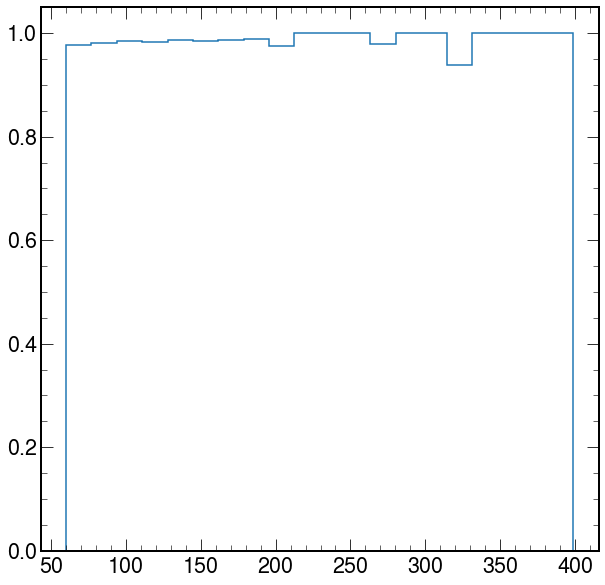

In [27]:
ratio_pt=np.array(pt_tc/pt_tr)
ratio_pt[np.isnan(ratio_pt)] = 0 
hep.histplot(ratio_pt,bins=bins_tr)
#colocar en y>0.6

In [28]:
ratio_pt

array([0.97753059, 0.98119122, 0.98543468, 0.98250525, 0.9874739 ,
       0.98407643, 0.98756219, 0.98943662, 0.9744898 , 1.        ,
       1.        , 1.        , 0.97916667, 1.        , 1.        ,
       0.9375    , 1.        , 1.        , 1.        , 1.        ])

# ETA

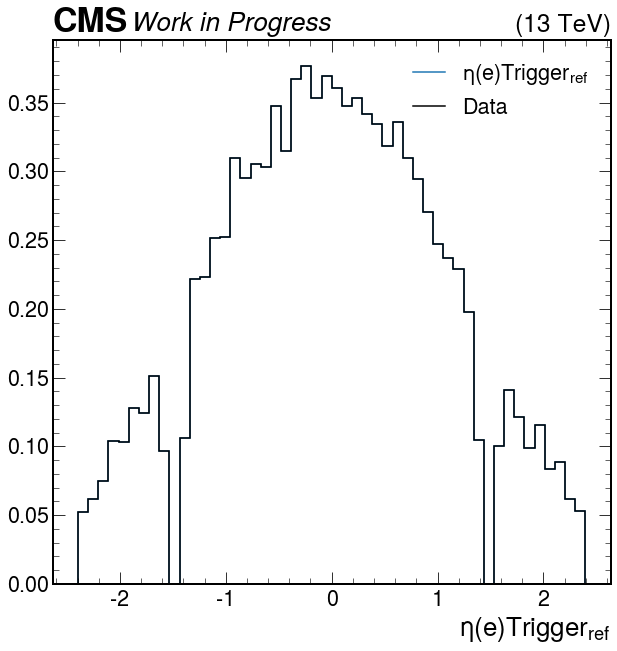

In [29]:

eta_e_tr=ak.firsts(candidtae_events.Electron.eta)
eta_tr,eta_bins_tr=plot_cms(eta_e_tr,bines=50,labels="$\eta(e) Trigger_{ref}$")

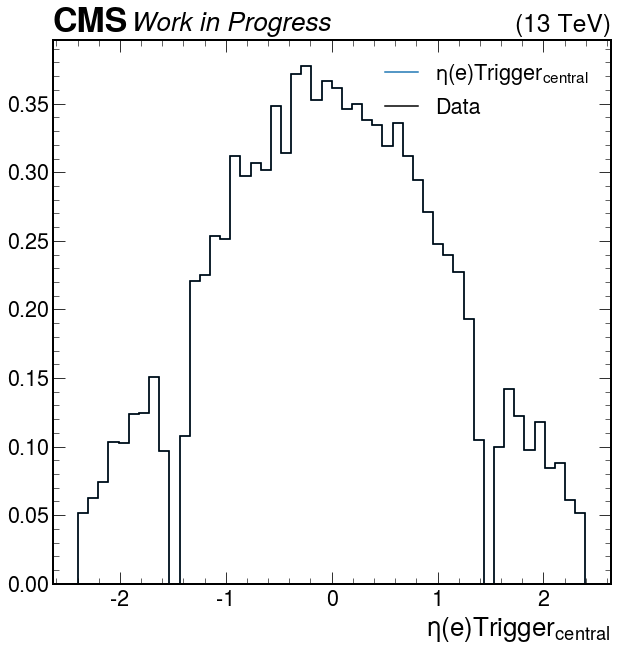

In [30]:
eta_e_tc=ak.firsts(event_select_c.Electron.eta)
eta_tc,eta_bins_tc=plot_cms(eta_e_tc,bines=eta_bins_tr,labels="$\eta(e)  Trigger_{central}$")

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fe85940d460>, errorbar=None, legend_artist=None)]

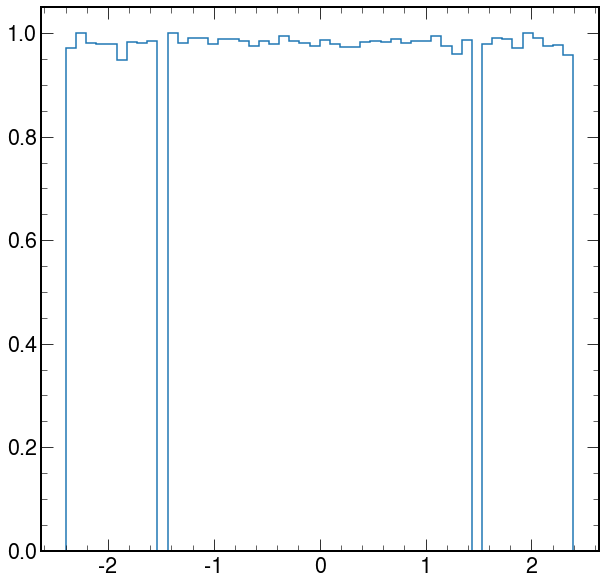

In [31]:
ratio_eta=np.array(eta_tc/eta_tr)
ratio_eta[np.isnan(ratio_eta)] = 0 
hep.histplot(ratio_eta,bins=eta_bins_tr)
#en y >0.8 para todas graf

# MET

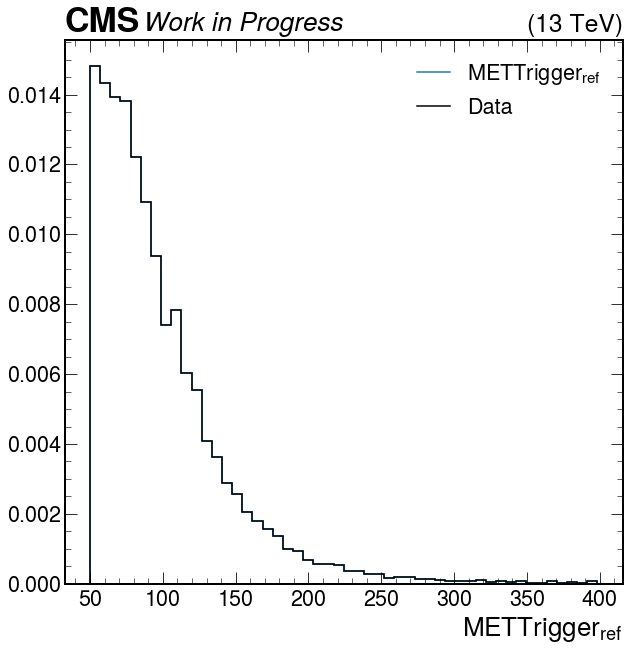

In [32]:
met_e_tr=candidtae_events.MET.pt
met_e_tr=met_e_tr[met_e_tr<400]
met_tr,met_bins_tr=plot_cms(met_e_tr,bines=50,labels="$MET Trigger_{ref}$")

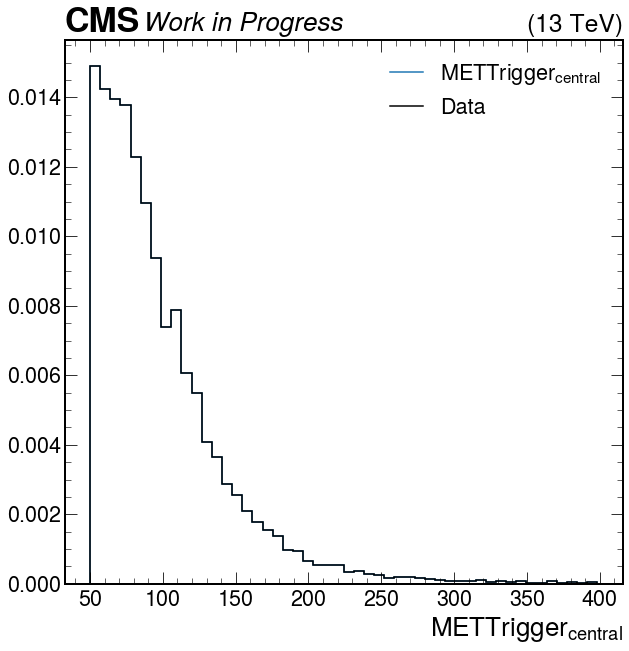

In [33]:
met_e_tc=event_select_c.MET.pt
met_e_tc=met_e_tc[met_e_tc<400]
met_tc,met_bins_tc=plot_cms(met_e_tc,bines=met_bins_tr,labels="$MET Trigger_{central}$")

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fe8590376a0>, errorbar=None, legend_artist=None)]

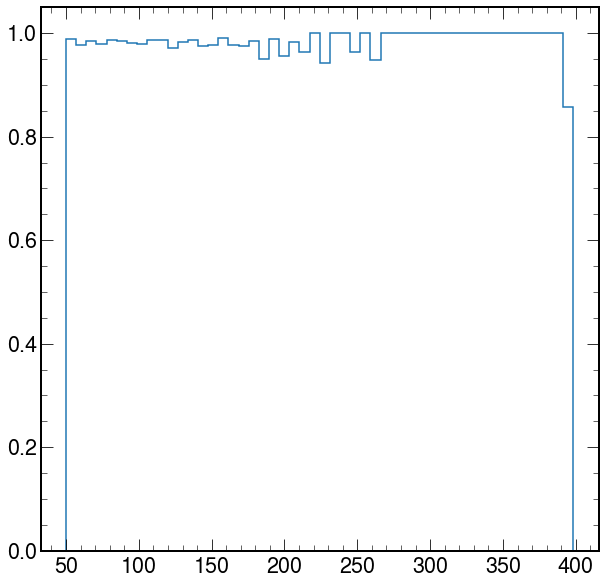

In [34]:
ratio_met=np.array(met_tc/met_tr)
ratio_met[np.isnan(ratio_met)] = 0 
hep.histplot(ratio_met,bins=met_bins_tr)

# $P_{T}$ b-jet

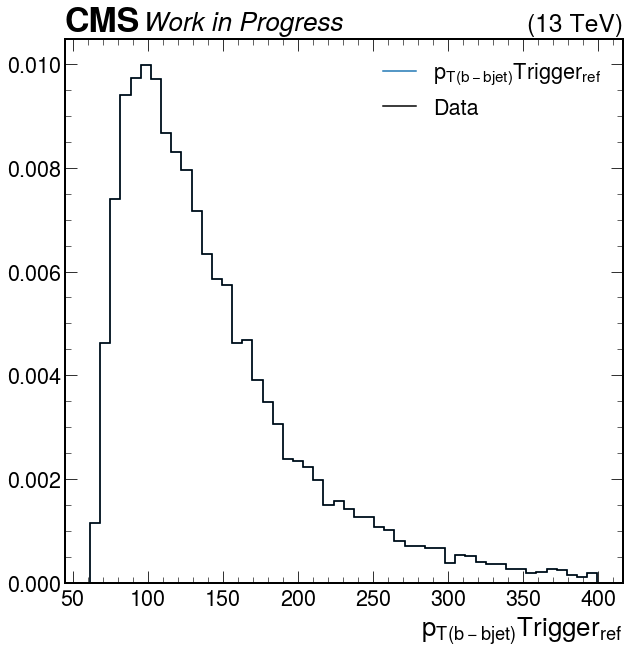

In [35]:
pt_jet_tr=ak.firsts(candidtae_events.Jet.pt)
pt_jet_tr=pt_jet_tr[pt_jet_tr<400]
jet_tr,bins_jet_tr=plot_cms(pt_jet_tr,bines=50,labels="${{p}_{T}}_{(b-bjet)} Trigger_{ref}$")

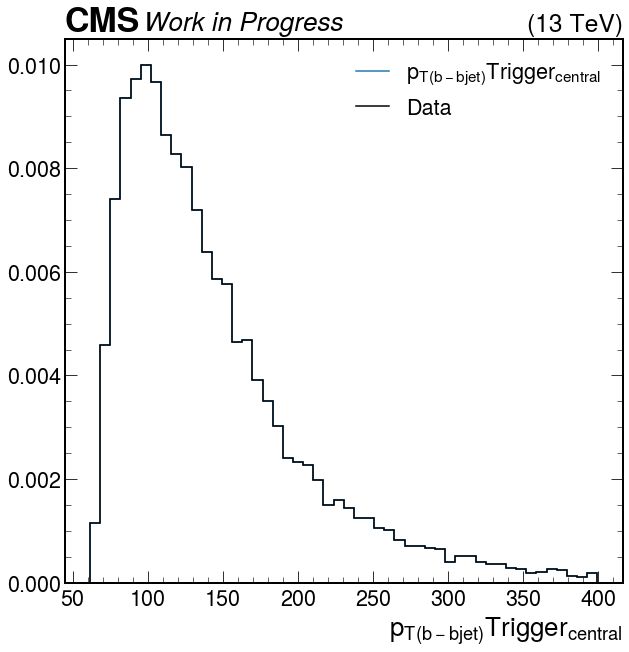

In [36]:
pt_jet_tc=ak.firsts(event_select_c.Jet.pt)
pt_jet_tc=pt_jet_tc[pt_jet_tc<400]
jet_tc,bins_jet_tc=plot_cms(pt_jet_tc,bines=bins_jet_tr,labels="${{p}_{T}}_{(b-bjet)} Trigger_{central}$")

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fe8594bf040>, errorbar=None, legend_artist=None)]

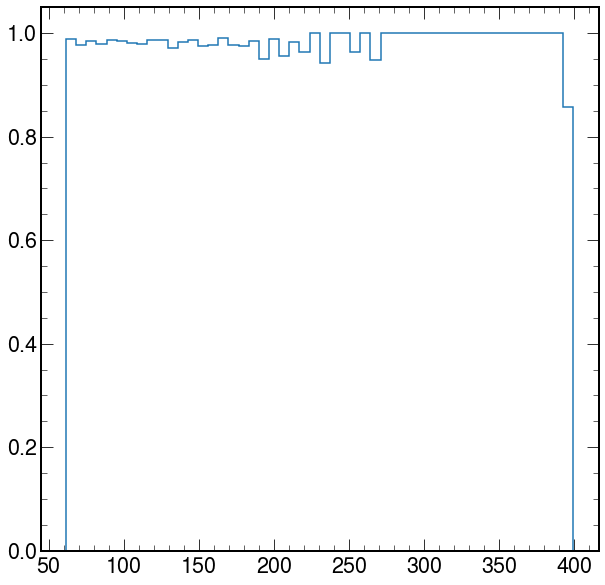

In [37]:
ratio_jet_pt=np.array(jet_tc/jet_tr)
ratio_jet_pt[np.isnan(ratio_jet_pt)] = 0 
hep.histplot(ratio_met,bins=bins_jet_tr)


# $\eta_{b-jet}$

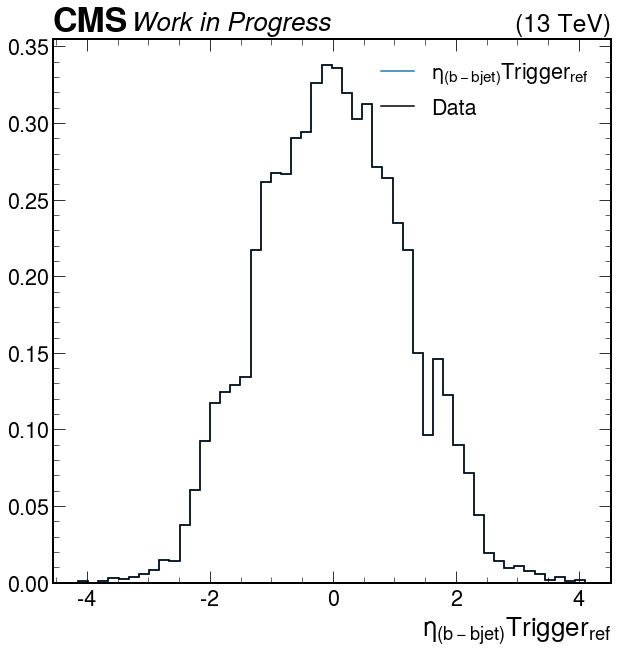

In [38]:
eta_jet_tr=ak.firsts(candidtae_events.Jet.eta)
jeteta_tr,bins_jeteta_tr=plot_cms(eta_jet_tr,bines=50,labels="${\eta}_{(b-bjet)} Trigger_{ref}$")

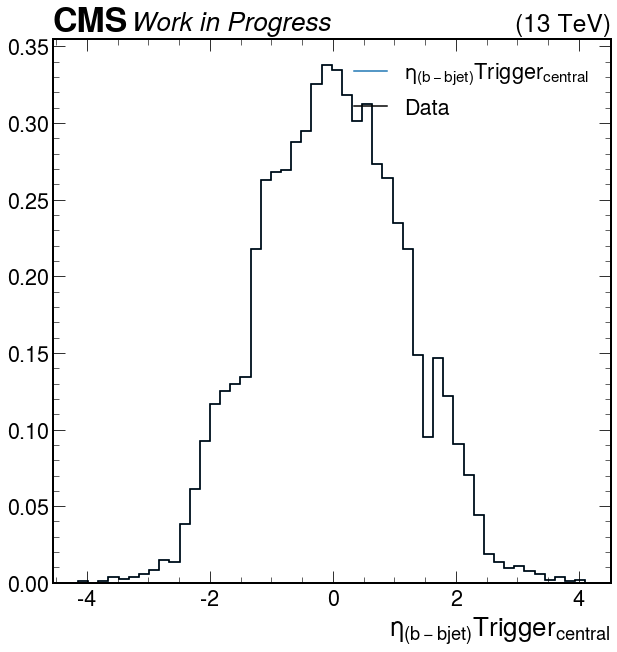

In [39]:
eta_jet_tc=ak.firsts(event_select_c.Jet.eta)
jeteta_tc,bins_jeteta_tc=plot_cms(eta_jet_tc,bines=bins_jeteta_tr,labels="${\eta}_{(b-bjet)} Trigger_{central}$")

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fe85955e910>, errorbar=None, legend_artist=None)]

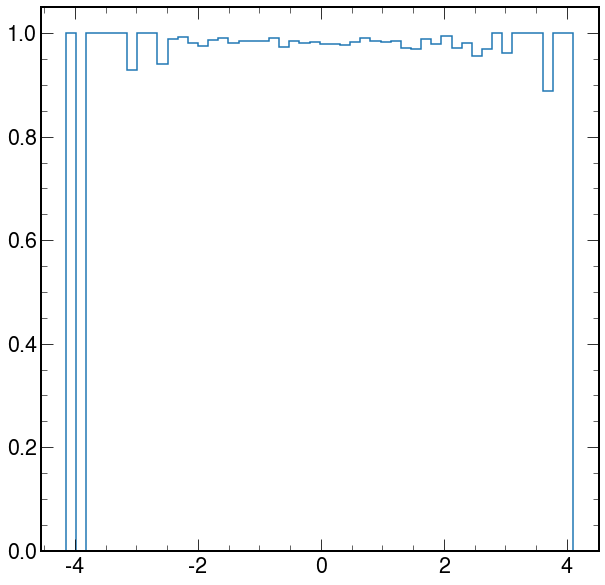

In [40]:
ratio_jet_eta=np.array(jeteta_tc/jeteta_tr)
ratio_jet_eta[np.isnan(ratio_jet_eta)] = 0 
hep.histplot(ratio_jet_eta,bins=bins_jeteta_tr)